# Часть 4. Feature engiering

Из прошлой части у нас есть подготовленный набор данных, на котором мы построили простую модель.  
В этой части попробуем добавить новые фичи для обучения.

In [1]:
import json
import pickle
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linearmodel import Ridge

Сделаем настройки ноубука

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = 12, 8
RANDOM_STATE=43

## Прочитаем набор полученный на предыдущем шаге

In [3]:
df = pd.read_csv('data1.csv')
print(f"{df.shape=}")

df.shape=(70896, 34)


C:\Soft\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Определим функции для дальнейшего анализа

* `score_model` - оценивает переданнух модель на кросс валидации, и выводит среднее значение метрики `mape`
* `make_submit` - делает предсказание модели на тестовых данныхЪ и сохраняет их в файл `predict.csv`
* `prepare_data` - подгаталивает тренировочный и тестовый набор (на основании переданного списка колонок)

In [9]:
def mape(y_true, y_pred):
    """оценка MEAN ABSOLUTE PERCENTAGE ERROR, которая используется в соревновании"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    
def score_model(model, X, y):
    """Оцениваем модель и данные на трех фолдах. Выводим средюю оценку, и оценки на фолдах"""
    
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    cv_results = cross_val_score(
        model, X, y, cv=kf, n_jobs=-1, scoring=make_scorer(mape))
    print("#"*100)
    print(model)
    print("#"*100)
    print(f'mean_result: {np.mean(cv_results)} ({cv_results})')
    print("#"*100)


def make_submit(model, X_test, submit_file='predict.csv'):
    """запишем предсказание модели в файл, готовый к отправке на kaggle"""
    pred = np.round(model.predict(X_test))
    answer = pd.Series(pred, index=df[~df.is_train].sell_id, name='price')
    answer.to_csv(submit_file, index_label='sell_id')


def prepare_data(categorical_columns: list, numerical_columns: list):
    """Вытащим требуемые данные из переменной df
    категориальные применим dummy кодирование
    числовые Шкалирование"""
    X = df.loc[:, categorical_columns+numerical_columns+['is_train']]

    X = pd.get_dummies(X, columns=categorical_columns)
    X[numerical_columns] = StandardScaler().fit_transform(X[numerical_columns])
    
    X_train = X[X.is_train == 1].drop('is_train', axis=1)
    X_test = X[X.is_train == 0].drop('is_train', axis=1)

    y = df[df.is_train].price

    return X_train, X_test, y

# Попробуем модель случайный лес

Попробуем модель случайный лес на имеющихся данных, и будем ее считать как начальный бейзлайн для дальнейшей работы с данными  
Случайный лес достаточно универсальная модель, которая к тому же показывает важность наших фич

In [5]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'engineDisplacement', 'mileage', ]

In [6]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [7]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [8]:
score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
####################################################################################################
mean_result: 14.627971553596899 ([14.61732591 14.92437233 14.34221642])
####################################################################################################


неплохие данные на крос-валидации. Давайте отправим на соревнование, но сначала натренируем модель на всех данных

In [10]:
model.fit(X_train,y);

In [11]:
mape(y, model.predict(X_train))

5.85675265294285

**Посмотрим на важные признаки модели**

In [12]:
pd.Series(model.feature_importances_,
          index=X_test.columns).sort_values(ascending=False).iloc[:20]

mileage                              0.36
engineDisplacement                   0.31
productionDate                       0.08
model_name_G-КЛАСС AMG               0.04
model_name_MAYBACH S-КЛАСС           0.03
brand_MERCEDES                       0.03
vehicleTransmission_автоматическая   0.02
model_name_SLR MCLAREN               0.01
Привод_передний                      0.01
Привод_задний                        0.01
Привод_полный                        0.01
model_name_G-КЛАСС                   0.01
vendor_EUROPEAN                      0.01
vehicleTransmission_механическая     0.01
model_name_GLE                       0.01
vendor_JAPANESE                      0.00
bodyType_минивэн                     0.00
model_name_W188                      0.00
model_name_V-КЛАСС                   0.00
Владельцы_1 владелец                 0.00
dtype: float64

в тесте обнуружились пропуски, пока уберем таким костылем

In [13]:
X_test.engineDisplacement.fillna(df.engineDisplacement.mean(), inplace=True)

In [14]:
make_submit(model, X_test) # 

**RandomForestRegressor(random_state=43)**  
CV mean_result: 14.63  
train mape 5.86
kaggle submit 13.86826

# Сделаем EDA

## Ищем корреляцию

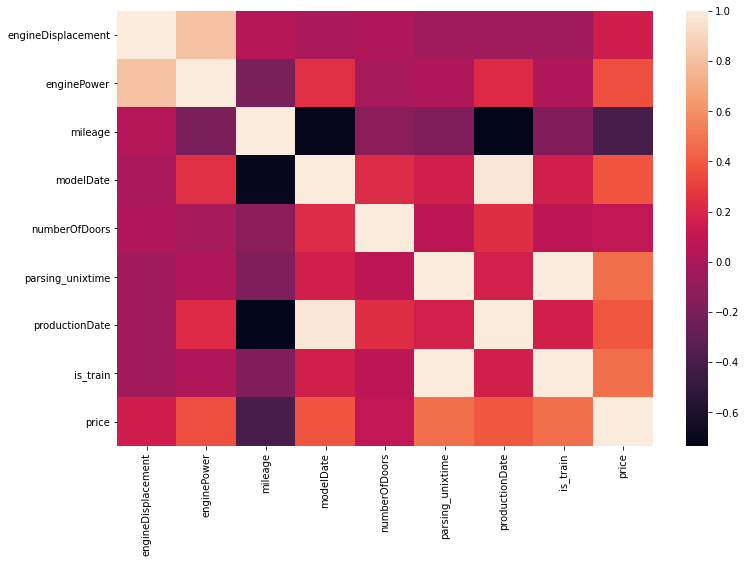

In [16]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(df.corr());

- из production_date и model_date - оставляем ону колонку
- bp engine dicplacement и engine power - оставляем одну колонку

## Сводная информация по колонкам, исследуем пропуски

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70896 entries, 0 to 70895
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              70896 non-null  object 
 1   brand                 70896 non-null  object 
 2   car_url               70896 non-null  object 
 3   color                 70896 non-null  object 
 4   complectation_dict    42628 non-null  object 
 5   description           69896 non-null  object 
 6   engineDisplacement    70841 non-null  float64
 7   enginePower           70896 non-null  float64
 8   equipment_dict        60900 non-null  object 
 9   fuelType              70896 non-null  object 
 10  image                 70896 non-null  object 
 11  mileage               70896 non-null  int64  
 12  modelDate             70896 non-null  float64
 13  model_info            70896 non-null  object 
 14  model_name            70896 non-null  object 
 15  name               

In [18]:
df.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description              1000
engineDisplacement         55
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                49577
ПТС                         0
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
is_train                    0
price     

complectation_dict, description, equipment_dict - это поля, из которых мы будем получать доп.сведения (если успеем)  
пока пропуски в этих полях не используем (как и сами поля)  

engineDisplacement надо заполнить, уже вылезло это в первой модели  

Владение - пока не используем, но нужно будет заполнить это поле потом

### Заполним пропуск engineDisplacement

посмотрим, какой тип топлива у незаполненных машин

In [19]:
df[df.engineDisplacement.isna()].fuelType.value_counts()

электро    55
Name: fuelType, dtype: int64

а у электро всегда ставят 0 объем

In [20]:
df[df.fuelType=='электро'].engineDisplacement.value_counts()

0.00    59
Name: engineDisplacement, dtype: int64

In [21]:
df.loc[df.fuelType=='электро','engineDisplacement'] = df.loc[df.fuelType=='электро','engineDisplacement'].fillna(0)

## price

целевая колонка распределена лог-нормально. Но пока оставим это как есть. Может быть потом будет использовать

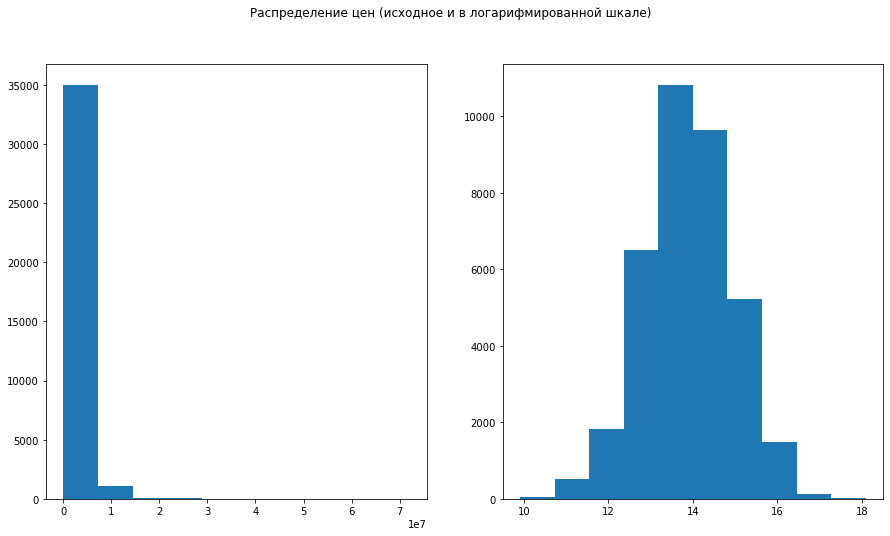

In [22]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df[df.is_train==1].price)
ax2.hist(np.log(df[df.is_train==1].price))
figure.suptitle('Распределение цен (исходное и в логарифмированной шкале)')
plt.show()

## bodyType

в колонке 25 значений, очень сильно по ним варьируется цена  
возможно стоит объединить все в более крупную схему (внедорожники все вместе, седаны, хетчбеки) - нужно проверить идею

In [23]:
df.bodyType.value_counts()

внедорожник 5 дв.          28277
седан                      24621
лифтбек                     4924
хэтчбек 5 дв.               3884
универсал 5 дв.             2490
минивэн                     1754
купе                        1578
компактвэн                   928
хэтчбек 3 дв.                855
пикап двойная кабина         569
внедорожник 3 дв.            248
купе-хардтоп                 217
кабриолет                    170
родстер                      150
фургон                       144
микровэн                      22
седан-хардтоп                 15
седан 2 дв.                   12
пикап одинарная кабина        11
лимузин                        9
пикап полуторная кабина        7
тарга                          4
внедорожник открытый           4
фастбек                        2
универсал 3 дв.1               1
Name: bodyType, dtype: int64

In [24]:
df.groupby(['bodyType', 'is_train'])['price'].agg(
    ['count', 'min', 'mean', 'max'])

count       min          mean       max
bodyType                is_train                                         
внедорожник 3 дв.       False       115         0          0.00         0
                        True        133    100000    455,878.29   3500000
внедорожник 5 дв.       False     12228         0          0.00         0
                        True      16049     79000  2,458,984.44  29300000
внедорожник открытый    False         3         0          0.00         0
                        True          1  15000000 15,000,000.00  15000000
кабриолет               False        90         0          0.00         0
                        True         80    470000  2,016,779.79  14781200
компактвэн              False       489         0          0.00         0
                        True        439     80000    574,575.83   2233100
купе                    False       824         0          0.00         0
                        True        754     70000  2,226,653.66  72000000
купе-хардтоп            False       158         0          0.00         0
                        True         59    230000  1,479,630.51   5200000
лимузин                 False         6         0          0.00         0
                        True          3   3500000  5,496,666.67   8000000
лифтбек                 False      2232         0          0.00         0
                        True       2692     27000    979,420.04  16650000
микровэн                False         7         0          0.00         0
                        True         15    140000    359,266.67    950000
минивэн                 False       995         0          0.00         0
                        True        759     60000  2,238,321.49  25500000
пикап двойная кабина    False       280         0          0.00         0
                        True        289    110000  1,458,609.65  12850000
пикап одинарная кабина  False         5         0          0.00         0
                        True          6    160000  1,784,166.67   4400000
пикап полуторная кабина False         5         0          0.00         0
                        True          2    399999  2,549,999.50   4700000
родстер                 False        99         0          0.00         0
                        True         51    295000  2,202,460.47  22500000
седан                   False     13147         0          0.00         0
                        True      11474     20000  1,420,625.03  58997576
седан 2 дв.             False         6         0          0.00         0
                        True          6    110000  1,058,333.33   2500000
седан-хардтоп           False        12         0          0.00         0
                        True          3     80000    200,000.00    370000
тарга                   False         2         0          0.00         0
                        True          2    120000    260,000.00    400000
универсал 3 дв.1        True          1    200000    200,000.00    200000
универсал 5 дв.         False      1276         0          0.00         0
                        True       1214     20000    893,912.74   6449000
фастбек                 False         1         0          0.00         0
                        True          1    598000    598,000.00    598000
фургон                  False        97         0          0.00         0
                        True         47    130000    674,102.02   2616600
хэтчбек 3 дв.           False       485         0          0.00         0
                        True        370     30000    412,978.25   2900000
хэтчбек 5 дв.           False      2124         0          0.00         0
                        True       1760     23000    550,573.39   6710400

In [25]:
bodyTypes = {
    'внедорожник открытый':'внедорожник',
    'внедорожник 5 дв.':'внедорожник',
    'седан':'седан',
    'лифтбек':'хэтчбек',
    'хэтчбек 5 дв.':'хэтчбек',
    'универсал 5 дв.':'универсал',
    'минивэн':'минивэн',
    'купе':'купе',
    'компактвэн':'минивэн',
    'хэтчбек 3 дв.':'хэтчбек',
    'пикап двойная кабина':'пикап',
    'внедорожник 3 дв.':'внедорожник',
    'купе-хардтоп':'купе',
    'кабриолет':'кабриолет',
    'родстер':'родстер',
    'фургон':'фургон',
    'микровэн':'минивэн',
    'седан-хардтоп':'седан',
    'седан 2 дв.':'седан',
    'пикап одинарная кабина':'пикап',
    'лимузин':'лимузин',
    'пикап полуторная кабина':'пикап',
    'внедорожник открытый':'внедорожник',
    'тарга':'родстер',
    'фастбек':'хэтчбек',
    'универсал 3 дв.1':'универсал',

}
df['bodyType_cut'] = df.bodyType.map(bodyTypes)


In [26]:
df.groupby(['bodyType_cut', 'is_train'])['price'].agg(
    ['count', 'min', 'mean', 'max'])

count      min         mean       max
bodyType_cut is_train                                       
внедорожник  False     12346        0         0.00         0
             True      16183    79000 2,443,296.86  29300000
кабриолет    False        90        0         0.00         0
             True         80   470000 2,016,779.79  14781200
купе         False       982        0         0.00         0
             True        813    70000 2,172,441.64  72000000
лимузин      False         6        0         0.00         0
             True          3  3500000 5,496,666.67   8000000
минивэн      False      1491        0         0.00         0
             True       1213    60000 1,612,954.49  25500000
пикап        False       290        0         0.00         0
             True        297   110000 1,472,535.98  12850000
родстер      False       101        0         0.00         0
             True         53   120000 2,129,160.08  22500000
седан        False     13165        0         0.00         0
             True      11483    20000 1,420,116.83  58997576
универсал    False      1276        0         0.00         0
             True       1215    20000   893,341.61   6449000
фургон       False        97        0         0.00         0
             True         47   130000   674,102.02   2616600
хэтчбек      False      4842        0         0.00         0
             True       4823    23000   779,392.05  16650000

## enginePower

Т.к. поля engine power и engine displacement - очень скоррелированы то нужно выбрать одно.  
у поля engine power есть преимущество, оно не рано 0 для электрокаров  
и расрпделение лог-нормально, можно прологарифмировать его

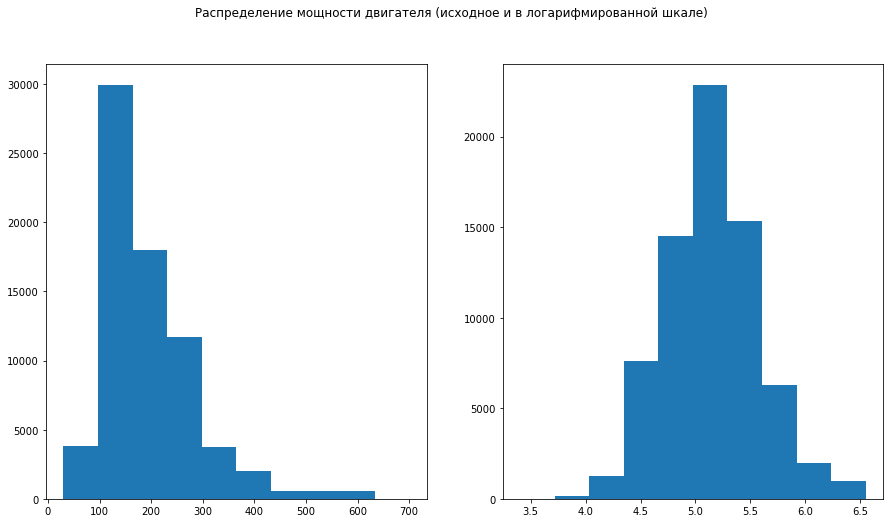

In [27]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.enginePower)
ax2.hist(np.log(df.enginePower))
figure.suptitle('Распределение мощности двигателя (исходное и в логарифмированной шкале)')
plt.show()

In [28]:
df['enginePower_log'] = np.log(df.enginePower)

## mileage

Поле конечно очень сильно влияет на цену авто.  
Отдельной категорией идут автомобили без пробега - выделим их отдельно  
и прологорифмируем колонку

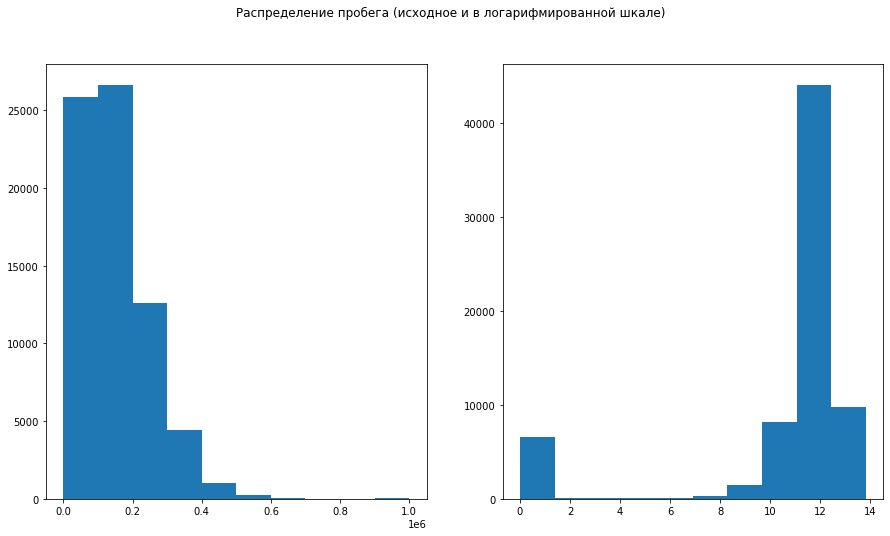

In [29]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.mileage)
ax2.hist(np.log(df.mileage+1))
figure.suptitle('Распределение пробега (исходное и в логарифмированной шкале)')
plt.show()

In [30]:
df['mileage_is_0'] = (df.mileage == 0)
df['mileage_log'] = np.log(df.mileage+1)

# Попробуем сделать модель еще раз, после доработки данных

In [31]:
cat_cols = ['bodyType', 'bodyType_cut', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', 'mileage_is_0']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]

In [32]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [33]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [34]:
score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
####################################################################################################
mean_result: 14.126372080372533 ([14.00349112 14.52744177 13.84818335])
####################################################################################################


## Увеличим количество деревьев

In [35]:
model = RandomForestRegressor(1000, random_state=RANDOM_STATE)

In [ ]:
score_model(model, X_train, y)

In [ ]:
model.fit(X_train,y);

In [ ]:
mape(y, model.predict(X_train))

In [37]:
pd.Series(model.feature_importances_,
          index=X_test.columns).sort_values(ascending=False).iloc[:20]

enginePower_log              0.41
mileage_log                  0.34
productionDate               0.07
model_name_G-КЛАСС AMG       0.03
model_name_G-КЛАСС           0.02
model_name_MAYBACH S-КЛАСС   0.02
model_name_W188              0.01
fuelType_дизель              0.01
fuelType_бензин              0.01
Привод_задний                0.01
Привод_полный                0.01
numberOfDoors                0.01
model_name_V-КЛАСС           0.01
brand_MERCEDES               0.00
model_name_CROWN             0.00
model_name_XC90              0.00
bodyType_седан               0.00
Владельцы_1 владелец         0.00
model_name_SLS AMG           0.00
model_name_LAND CRUISER      0.00
dtype: float64

In [38]:
make_submit(model, X_test) #13.50994

## Попробуем также CatBoost на этом наборе

In [19]:
X_train = df[df.is_train].drop('price', axis=1).loc[:, cat_cols+num_cols]
y = df[df.is_train].price

In [20]:
model = CatBoostRegressor(cat_features=cat_cols, random_state=RANDOM_STATE)

In [21]:
score_model(model, X_train, y)

####################################################################################################
####################################################################################################
mean_result: 15.663132304340564 ([16.10804208 16.06132546 14.82002938])
####################################################################################################


In [23]:
model.fit(X, y)

Learning rate set to 0.073939
0:	learn: 2220260.1488037	total: 213ms	remaining: 3m 33s
1:	learn: 2104907.9400144	total: 287ms	remaining: 2m 23s
2:	learn: 2000080.8198198	total: 359ms	remaining: 1m 59s
3:	learn: 1901041.4507333	total: 427ms	remaining: 1m 46s
4:	learn: 1809889.1647393	total: 504ms	remaining: 1m 40s
5:	learn: 1726446.6690871	total: 567ms	remaining: 1m 33s
6:	learn: 1652984.9984410	total: 660ms	remaining: 1m 33s
7:	learn: 1582270.5220615	total: 733ms	remaining: 1m 30s
8:	learn: 1514786.5586182	total: 791ms	remaining: 1m 27s
9:	learn: 1452422.3069093	total: 856ms	remaining: 1m 24s
10:	learn: 1393613.8081902	total: 927ms	remaining: 1m 23s
11:	learn: 1343039.8717210	total: 982ms	remaining: 1m 20s
12:	learn: 1297011.0474310	total: 1.04s	remaining: 1m 18s
13:	learn: 1249904.2301398	total: 1.11s	remaining: 1m 17s
14:	learn: 1207265.0432922	total: 1.17s	remaining: 1m 17s
15:	learn: 1171192.8259362	total: 1.24s	remaining: 1m 16s
16:	learn: 1136506.0831458	total: 1.32s	remaining: 1

147:	learn: 543735.6982051	total: 10.9s	remaining: 1m 2s
148:	learn: 543355.6573249	total: 11s	remaining: 1m 2s
149:	learn: 543188.9232625	total: 11s	remaining: 1m 2s
150:	learn: 543029.1744320	total: 11.1s	remaining: 1m 2s
151:	learn: 542658.8840742	total: 11.1s	remaining: 1m 2s
152:	learn: 542263.5643934	total: 11.2s	remaining: 1m 2s
153:	learn: 541930.7865515	total: 11.3s	remaining: 1m 1s
154:	learn: 541558.8619660	total: 11.3s	remaining: 1m 1s
155:	learn: 541228.2278791	total: 11.4s	remaining: 1m 1s
156:	learn: 540902.9596636	total: 11.5s	remaining: 1m 1s
157:	learn: 539734.4447613	total: 11.5s	remaining: 1m 1s
158:	learn: 536428.2421164	total: 11.6s	remaining: 1m 1s
159:	learn: 536198.9615310	total: 11.7s	remaining: 1m 1s
160:	learn: 534237.7973354	total: 11.7s	remaining: 1m 1s
161:	learn: 532257.8047265	total: 11.8s	remaining: 1m 1s
162:	learn: 530574.7095153	total: 11.9s	remaining: 1m
163:	learn: 530455.9580682	total: 11.9s	remaining: 1m
164:	learn: 529329.7003446	total: 12s	rem

295:	learn: 451249.9087611	total: 20.4s	remaining: 48.4s
296:	learn: 451183.4157074	total: 20.4s	remaining: 48.4s
297:	learn: 451117.9841014	total: 20.5s	remaining: 48.3s
298:	learn: 450962.7887302	total: 20.6s	remaining: 48.3s
299:	learn: 450568.3362944	total: 20.6s	remaining: 48.2s
300:	learn: 450261.4606725	total: 20.7s	remaining: 48.1s
301:	learn: 450203.4048040	total: 20.8s	remaining: 48s
302:	learn: 449953.4033338	total: 20.8s	remaining: 47.9s
303:	learn: 449640.9030372	total: 20.9s	remaining: 47.9s
304:	learn: 449210.1781147	total: 21s	remaining: 47.8s
305:	learn: 448930.4654517	total: 21s	remaining: 47.7s
306:	learn: 448772.1912707	total: 21.1s	remaining: 47.6s
307:	learn: 447877.4587845	total: 21.2s	remaining: 47.6s
308:	learn: 447129.5129686	total: 21.2s	remaining: 47.5s
309:	learn: 446831.2141779	total: 21.3s	remaining: 47.4s
310:	learn: 446522.9678752	total: 21.4s	remaining: 47.3s
311:	learn: 445937.1252194	total: 21.4s	remaining: 47.2s
312:	learn: 445654.7742370	total: 21.

440:	learn: 406678.2410809	total: 29.9s	remaining: 37.9s
441:	learn: 406434.3443582	total: 29.9s	remaining: 37.8s
442:	learn: 406341.3217360	total: 30s	remaining: 37.7s
443:	learn: 406288.6356077	total: 30.1s	remaining: 37.7s
444:	learn: 405996.6968130	total: 30.1s	remaining: 37.6s
445:	learn: 405938.0252825	total: 30.2s	remaining: 37.5s
446:	learn: 405742.8681410	total: 30.3s	remaining: 37.4s
447:	learn: 405414.5460987	total: 30.3s	remaining: 37.4s
448:	learn: 405251.2781569	total: 30.4s	remaining: 37.3s
449:	learn: 404846.6780111	total: 30.5s	remaining: 37.2s
450:	learn: 404627.9442347	total: 30.5s	remaining: 37.2s
451:	learn: 404010.7863647	total: 30.6s	remaining: 37.1s
452:	learn: 403791.9964575	total: 30.7s	remaining: 37s
453:	learn: 403535.4434138	total: 30.7s	remaining: 37s
454:	learn: 403447.1080970	total: 30.8s	remaining: 36.9s
455:	learn: 403301.9756001	total: 30.9s	remaining: 36.8s
456:	learn: 403078.8231453	total: 30.9s	remaining: 36.8s
457:	learn: 403021.6912378	total: 31s

585:	learn: 375238.3114723	total: 39.7s	remaining: 28s
586:	learn: 374903.3887609	total: 39.7s	remaining: 27.9s
587:	learn: 374738.0626467	total: 39.8s	remaining: 27.9s
588:	learn: 374734.9945129	total: 39.9s	remaining: 27.8s
589:	learn: 374664.8748711	total: 39.9s	remaining: 27.7s
590:	learn: 374659.0021580	total: 40s	remaining: 27.7s
591:	learn: 374509.7832280	total: 40s	remaining: 27.6s
592:	learn: 374236.3267127	total: 40.1s	remaining: 27.5s
593:	learn: 374145.4566972	total: 40.2s	remaining: 27.5s
594:	learn: 373939.1138703	total: 40.2s	remaining: 27.4s
595:	learn: 373851.4197058	total: 40.3s	remaining: 27.3s
596:	learn: 373389.7453617	total: 40.4s	remaining: 27.3s
597:	learn: 373319.6937153	total: 40.4s	remaining: 27.2s
598:	learn: 373187.8797042	total: 40.5s	remaining: 27.1s
599:	learn: 373185.0333434	total: 40.6s	remaining: 27s
600:	learn: 372848.6474465	total: 40.6s	remaining: 27s
601:	learn: 372843.1443598	total: 40.7s	remaining: 26.9s
602:	learn: 372483.0696132	total: 40.8s	r

730:	learn: 354830.0820243	total: 49.3s	remaining: 18.2s
731:	learn: 354785.0750309	total: 49.4s	remaining: 18.1s
732:	learn: 354768.7463994	total: 49.5s	remaining: 18s
733:	learn: 354751.4169111	total: 49.5s	remaining: 17.9s
734:	learn: 354598.9250910	total: 49.6s	remaining: 17.9s
735:	learn: 354274.3831123	total: 49.7s	remaining: 17.8s
736:	learn: 354156.7142034	total: 49.7s	remaining: 17.8s
737:	learn: 353967.0934024	total: 49.8s	remaining: 17.7s
738:	learn: 353963.2745940	total: 49.9s	remaining: 17.6s
739:	learn: 353959.9217464	total: 50s	remaining: 17.6s
740:	learn: 353856.5184178	total: 50.1s	remaining: 17.5s
741:	learn: 353820.1523415	total: 50.2s	remaining: 17.5s
742:	learn: 353516.6400212	total: 50.3s	remaining: 17.4s
743:	learn: 353485.6518826	total: 50.4s	remaining: 17.3s
744:	learn: 353226.8274407	total: 50.4s	remaining: 17.3s
745:	learn: 353162.7167207	total: 50.5s	remaining: 17.2s
746:	learn: 353128.2902653	total: 50.6s	remaining: 17.1s
747:	learn: 353102.9832465	total: 5

877:	learn: 337833.2389196	total: 59.5s	remaining: 8.27s
878:	learn: 337726.8710871	total: 59.5s	remaining: 8.2s
879:	learn: 337618.6704613	total: 59.6s	remaining: 8.13s
880:	learn: 337568.0008547	total: 59.7s	remaining: 8.06s
881:	learn: 337383.6917351	total: 59.7s	remaining: 7.99s
882:	learn: 337321.2274242	total: 59.8s	remaining: 7.92s
883:	learn: 337286.9487203	total: 59.9s	remaining: 7.86s
884:	learn: 337261.9410543	total: 60s	remaining: 7.79s
885:	learn: 337174.7910336	total: 1m	remaining: 7.72s
886:	learn: 337096.1648146	total: 1m	remaining: 7.66s
887:	learn: 336923.2820456	total: 1m	remaining: 7.59s
888:	learn: 336647.7021039	total: 1m	remaining: 7.52s
889:	learn: 336578.3065174	total: 1m	remaining: 7.45s
890:	learn: 336543.4440259	total: 1m	remaining: 7.38s
891:	learn: 336487.7437807	total: 1m	remaining: 7.32s
892:	learn: 336411.9685340	total: 1m	remaining: 7.25s
893:	learn: 336352.9955495	total: 1m	remaining: 7.18s
894:	learn: 336165.8692555	total: 1m	remaining: 7.11s
895:	le

In [24]:
pd.Series(model.get_feature_importance(),
          index=model.feature_names_).sort_values(ascending=False)

enginePower_log       35.98
productionDate        19.36
mileage_log           15.42
brand                  8.10
model_name             4.90
Привод                 4.73
fuelType               4.16
Владельцы              2.31
bodyType               1.66
vehicleTransmission    1.26
color                  0.84
bodyType_cut           0.77
vendor                 0.28
numberOfDoors          0.19
ПТС                    0.03
Руль                   0.01
mileage_is_0           0.00
dtype: float64

## Линейная регрессия

In [26]:
model = Ridge(alpha=7)

In [27]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [28]:
score_model(model, X_train, y)

####################################################################################################
Ridge(alpha=7)
####################################################################################################
mean_result: 65.34129770557168 ([67.55981185 66.28554534 62.17853592])
####################################################################################################


In [29]:
model.fit(X_train, y)

Ridge(alpha=7)

In [33]:
coefs = pd.Series(model.coef_, index=X_train.columns)
coefs[coefs==0].index.values

array(['color_бежевый', 'color_коричневый', 'color_пурпурный',
       'color_серебристый', 'model_name_02', 'model_name_100_SERIES',
       'model_name_120', 'model_name_140', 'model_name_190_SL',
       'model_name_1ER', 'model_name_200SX', 'model_name_240_SERIES',
       'model_name_2ACTIVETOURER', 'model_name_2ER',
       'model_name_2GRANDTOURER', 'model_name_3ER', 'model_name_4',
       'model_name_5ER', 'model_name_6ER', 'model_name_7ER',
       'model_name_8ER', 'model_name_A4_ALLROAD', 'model_name_ALLROAD',
       'model_name_ALMERA_CLASSIC', 'model_name_ALMERA_TINO',
       'model_name_AMG_GLC_COUPE', 'model_name_AMG_GT',
       'model_name_ARTEON', 'model_name_ASPIRE',
       'model_name_AVENSIS_VERSO', 'model_name_A_KLASSE',
       'model_name_A_KLASSE_AMG', 'model_name_BLUEBIRD_SYLPHY',
       'model_name_B_KLASSE', 'model_name_CAMRY_SOLARA',
       'model_name_CARAVAN_COACH', 'model_name_CARINA_E',
       'model_name_CARINA_ED', 'model_name_CIVIC_FERIO',
       'model_name

На текущем наборе выигрывает Случайный лес.  
Линейная регрессия очень плохо справилась, но зато можно посмотреть какие коэффициенты она обнулала.
Ridge регрессия обнулила 200 коэффициентов, в основном это dummy колонки по model_name

продолжим исследовать данные дальше.

# Исследуем данные дальше

## model_date & production_date

Распределение почти одинаковое.   
А что если добавить колонку разницу этих дат  
Ну и по корреляции уже поняли что нужно использовать только одну из этих колонок

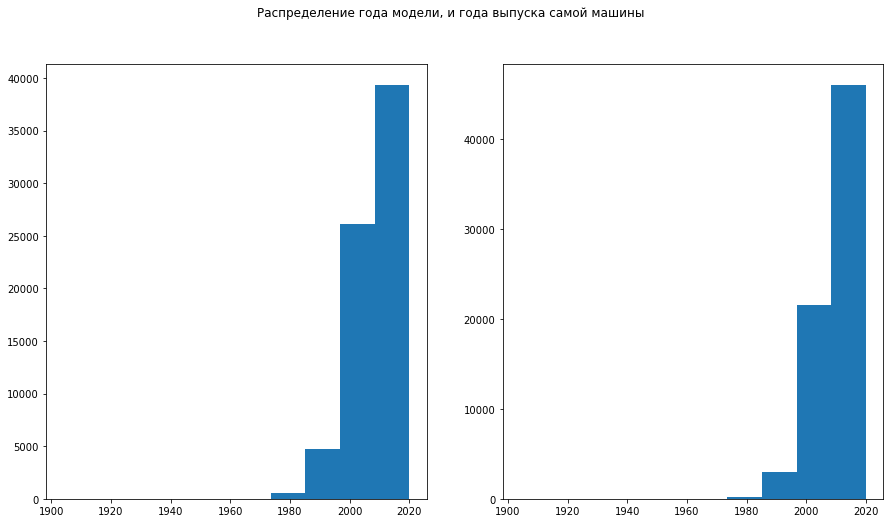

In [36]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.modelDate)
ax2.hist(df.productionDate)
figure.suptitle('Распределение года модели, и года выпуска самой машины')
plt.show()

In [37]:
df['diff_date_model_production'] = df.productionDate-df.modelDate

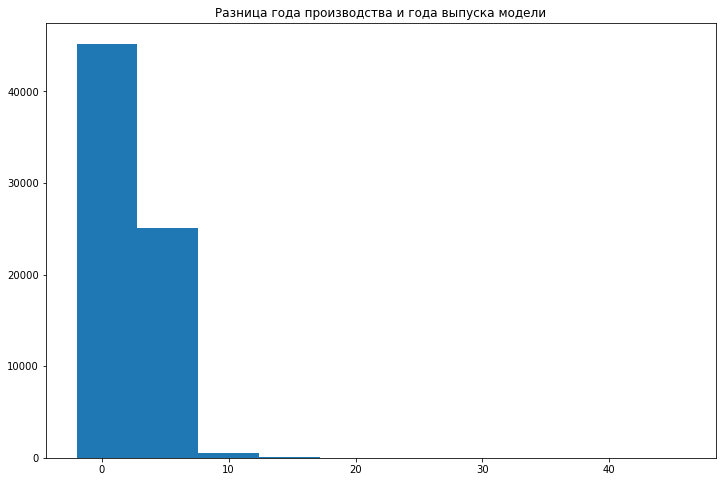

In [38]:
plt.hist(df.diff_date_model_production)
plt.title('Разница года производства и года выпуска модели')
plt.show();

## model_name

В текущем наборе мы эту колонку сделали dummy колонкой и наша Ridge модель обнулила много коэффициентов по ней  
наверное стоит сделать ограничение на эту колонку, чтобы не засорять модель 733 новыми колонками  
определим, сколько моделей стоит учитывать  

увидел что в колонке есть значение с пробелами и с подчеркиваниями (наверное в тесте и в трейне разные парсеры) - исправим это  
думаю 50 моделей - нормальное число, как раз только 50 моделей встерчаются более 500 раз, остальные меньше

In [39]:
df.model_name = df.model_name.str.replace(' ', '_')

In [40]:
df.model_name.value_counts()[40:60]

S_KLASSE        549
GLE             536
YETI            529
RAV4            515
FABIA           515
SUPERB          514
PAJERO_SPORT    487
CR-V            466
JUKE            452
RAV_4           447
A3              446
MURANO          433
C_KLASSE        428
KODIAQ          428
A5              426
S80             416
A8              413
LX              413
ASX             404
X1              396
Name: model_name, dtype: int64

In [41]:
top_models = df.model_name.value_counts()[:50].index
df['model_name_cut'] = df.model_name
df.loc[~df.model_name.isin(top_models), 'model_name_cut'] = 'RARE_MODEL'

In [42]:
df.model_name_cut.value_counts()

RARE_MODEL            28037
OCTAVIA                2835
OUTLANDER              1604
LANCER                 1544
POLO                   1457
A6                     1360
PASSAT                 1317
QASHQAI                1315
CAMRY                  1314
A4                     1265
X5                     1213
TIGUAN                 1122
5ER                    1026
RAPID                  1021
XC90                    958
LAND_CRUISER            955
TOUAREG                 877
XC60                    860
COROLLA                 828
CIVIC                   828
X-TRAIL                 818
E_KLASSE                809
ALMERA                  786
3ER                     752
RX                      721
3_СЕРИИ                 720
LAND_CRUISER_PRADO      716
ACCORD                  698
GOLF                    686
JETTA                   658
FX                      655
X_TRAIL                 654
E-КЛАСС                 652
Q5                      645
5_СЕРИИ                 631
PAJERO              

## Владельцы

заменим категориальную переменну числом, ведь это ординальная ,3 владельца болье чем 2 и 2 больше чем 1  
но что ставить когда неизвестно! если пробег 0, то и владельцев 0  
а если пробег больше 0 то ставим 2 владельца - как среднее в нашей выборке  


In [43]:
df['Владельцы'].value_counts()

3 или более    29078
1 владелец     18197
2 владельца    17001
Неизвестно      6620
Name: Владельцы, dtype: int64

In [44]:
df['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', 'Неизвестно'],
      dtype=object)

In [45]:
df[df['Владельцы'] == 'Неизвестно'].mileage.value_counts()

0         6616
130000       1
160000       1
119000       1
280000       1
Name: mileage, dtype: int64

In [46]:
mask = (df['Владельцы'] == 'Неизвестно') & (df.mileage == 0)
df.loc[mask, 'Владельцы'] = "Новая машина"
mask = (df['Владельцы'] == 'Неизвестно') & (df.mileage != 0)
df.loc[mask, 'Владельцы'] = "2\xa0владельца"

In [47]:
df['Владельцы'].value_counts()

3 или более     29078
1 владелец      18197
2 владельца     17005
Новая машина     6616
Name: Владельцы, dtype: int64

In [48]:
df['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', 'Новая машина'],
      dtype=object)

In [49]:
owners_map = {
    'Новая машина':0,
    '1\xa0владелец':1,
    '2\xa0владельца':2,
    '3 или более':3    
}
df['owners'] = df['Владельцы'].map(owners_map)

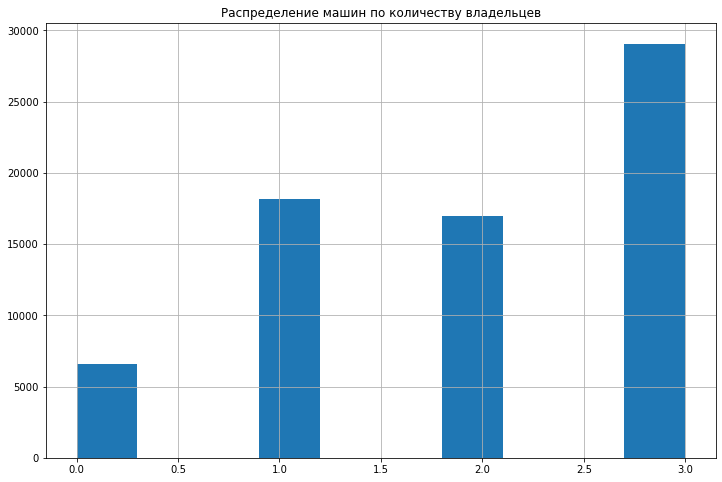

In [50]:
df.owners.hist();
plt.title('Распределение машин по количеству владельцев');

## Владение

много пропущенных значений, больше половины набора данных  
сделаем колонку что срок владения укзаан, и больше ничего не будем делать  

In [51]:
print(f"процент пропущенных значений: {df['Владение'].isna().sum() / df.shape[0]}")

процент пропущенных значений: 0.699291920559693


In [52]:
df['Владение'].value_counts()

1 год и 10 месяцев             209
2 года                         197
1 год                          194
1 год и 1 месяц                193
1 год и 2 месяца               187
                              ... 
{'year': 1977, 'month': 12}      1
21 год и 9 месяцев               1
21 год и 4 месяца                1
{'year': 2002, 'month': 6}       1
{'year': 1992, 'month': 2}       1
Name: Владение, Length: 538, dtype: int64

In [53]:
df['own_time_is_na'] = df['Владение'].isna()

# Выбираем данные для модели, которые будут давать лучшие результаты

Попробуем выбрать набор признаков, который будет давать лучший прогноз. Выбирать будем на случайном лесе из 100 деревьев

**Результаты:**
- model_name_cut - плохо
- bodyType_cut - плохо
- mileage_is_0 - плохо
- owners - плохо
- diff_date_model_production - **хорошо**
- own_time_is_na - плохо

печально, только один новый признак оказался полезным для модели, ну да ладно.

In [54]:
cat_cols = ['bodyType', 'bodyType_cut', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', 'mileage_is_0']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]

In [55]:
X_train2, X_test2, y2 = prepare_data(cat_cols, num_cols)

In [ ]:
score_model(model, X_train2, y2)

In [201]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', 'mileage_is_0']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]

In [202]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [203]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [204]:
score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
####################################################################################################
mean_result: 14.100198948770993 ([13.97008487 14.49558397 13.834928  ])
####################################################################################################


In [209]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]
X_train, X_test, y = prepare_data(cat_cols, num_cols)
model = RandomForestRegressor(100, random_state=RANDOM_STATE)
score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
####################################################################################################
mean_result: 14.092390584403361 ([13.98608792 14.4967602  13.79432364])
####################################################################################################


In [218]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'owners']
X_train, X_test, y = prepare_data(cat_cols, num_cols)
model = RandomForestRegressor(100, random_state=RANDOM_STATE)
score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
####################################################################################################
mean_result: 14.115599327500243 ([13.99013874 14.49816243 13.85849682])
####################################################################################################


In [212]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production']
X_train, X_test, y = prepare_data(cat_cols, num_cols)
model = RandomForestRegressor(100, random_state=RANDOM_STATE)
score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
####################################################################################################
mean_result: 14.034526509801124 ([13.88094322 14.38738953 13.83524678])
####################################################################################################


In [219]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль', 'own_time_is_na']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', ]
X_train, X_test, y = prepare_data(cat_cols, num_cols)
model = RandomForestRegressor(100, random_state=RANDOM_STATE)
score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
####################################################################################################
mean_result: 14.114809638838196 ([13.98677315 14.49627986 13.8613759 ])
####################################################################################################


Лучший набор признаков получился такой

In [220]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production']

# Попробуем catboost снова с указанием гиперпарамеров, и с валидацией

In [223]:
X = df[df.is_train].drop('price', axis=1).loc[:, cat_cols+num_cols]
y = df[df.is_train].price

In [227]:
# CATBOOST
ITERATIONS = 2000
LR         = 0.1
VAL_SIZE   = 0.3

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_STATE)

In [233]:
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_STATE,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, y_train,
         cat_features=cat_cols,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.9721047	test: 2.0433918	best: 2.0433918 (0)	total: 199ms	remaining: 6m 38s
100:	learn: 0.2239498	test: 0.2242109	best: 0.2242109 (100)	total: 5.71s	remaining: 1m 47s
200:	learn: 0.1839868	test: 0.1861667	best: 0.1861667 (200)	total: 12.2s	remaining: 1m 48s
300:	learn: 0.1698125	test: 0.1733081	best: 0.1733081 (300)	total: 18.2s	remaining: 1m 42s
400:	learn: 0.1603033	test: 0.1658301	best: 0.1658301 (400)	total: 23.9s	remaining: 1m 35s
500:	learn: 0.1543331	test: 0.1609996	best: 0.1609996 (500)	total: 29.9s	remaining: 1m 29s
600:	learn: 0.1500164	test: 0.1584658	best: 0.1584658 (600)	total: 35.9s	remaining: 1m 23s
700:	learn: 0.1460118	test: 0.1555214	best: 0.1554597 (698)	total: 42.4s	remaining: 1m 18s
800:	learn: 0.1428344	test: 0.1542262	best: 0.1540887 (797)	total: 48.7s	remaining: 1m 12s
900:	learn: 0.1399042	test: 0.1525721	best: 0.1525029 (885)	total: 55.7s	remaining: 1m 7s
1000:	learn: 0.1376704	test: 0.1515352	best: 0.1514698 (989)	total: 1m 2s	remaining: 1m 1s
1100

In [234]:
mape(y_test, model.predict(X_test))

14.545243417503343

## Случайный лес на 2000 деревьев

In [235]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production']
X_train, X_test, y = prepare_data(cat_cols, num_cols)
model = RandomForestRegressor(2000, random_state=RANDOM_STATE)
score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(n_estimators=2000, random_state=43)
####################################################################################################
mean_result: 13.989654599567034 ([13.80905142 14.32171239 13.83819999])
####################################################################################################


Случайный лес из 2000 деревьев дает лучший результат.

In [239]:
model.fit(X_train, y)

RandomForestRegressor(n_estimators=2000, random_state=43)

In [240]:
mape(y, model.predict(X_train))

5.48188782277227

In [241]:
make_submit(model, X_test) # 12.92800

In [242]:
import pickle
filename = '4.7.1random_forest_2000.sav'
pickle.dump(model, open(filename, 'wb'))

## XGBOOST


In [1]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production']

In [ ]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000, silent=1)
xg_reg.fit(X_train, y_train)
xg_red_pred = xg_reg.predict(X_val)

# Генерируем новые фичи из дополнительных колонок

Есть 5 дополнительных полей, из которых можно генерировать новые фичи, но нужно их анализировать

In [ ]:
df[['description','complectation_dict','equipment_dict','model_info','super_gen']].head()

## equipment_dict

В поле содержится json или python dict (я в трейне так спарсил).
В этом объекте содержится значений опций присутствующих у авто. если значения нет, то и опция у машины не указана
Можно из каждой опции сделать отдельную колонку бинарную.
правда есть проблема, если вообще у колонки не указаны опции вообще, то и эта конкретная не известно есть или нет.
Возможно имеет смысле ввести 3 значения: опция есть, опции указаны и этой опции нет, опции вообще не указаны. Но я это делать не буду.
И так в наборе очень много колонок получается, и очень долго тренирутся модель.

По результатам приминения этих данных получилось следующее:
- модель сильно усложняется, очень сильно увеличивается время обучения о
- на трейне результат хорошо увеличивается
- но на лидерборде результат стал хуже

Было принято решение дальше не исползовать эти колонки, потому что времени уже нету, и они не дают результата на тесте.

In [68]:
df[['equipment_dict','is_train']].sample().values

array([["{'esp': True, 'airbag-driver': True, 'electro-window-front': True, 'xenon': True, 'airbag-passenger': True, 'computer': True, 'seat-transformation': True, 'wheel-power': True, 'alarm': True, 'passenger-seat-electric': True, 'lock': True, 'electro-mirrors': True, 'electro-window-back': True, 'ptf': True, 'airbag-side': True, 'mirrors-heat': True, 'audiosystem-cd': True, 'leather': True, 'abs': True, 'front-seats-heat': True, 'wheel-configuration2': True, 'wheel-configuration1': True, 'immo': True, 'climate-control-1': True}",
        True]], dtype=object)

In [26]:
def parse_dict_column(row, column_name):
    if row[column_name] is np.nan:
        return None
    if row.is_train:
        return eval(row[column_name])
    else:
        return json.loads(row[column_name])

In [35]:
equipment_series = df.apply(partial(parse_dict_column, column_name='equipment_dict'), axis=1)
equipment_dataframe = equipment_series.apply(pd.Series)
equipment_dataframe.fillna(False, inplace=True)

In [40]:
equipment_dataframe.head()

,engine-proof,tinted-glass,airbag-driver,aux,isofix,electro-window-front,ashtray-and-cigarette-lighter,airbag-passenger,computer,high-beam-assist,seat-transformation,isofix-front,wheel-power,alarm,lock,door-sill-panel,fabric-seats,electro-mirrors,airbag-rear-side,electro-window-back,steel-wheels,ptf,16-inch-wheels,rain-sensor,airbag-side,audiosystem-cd,dark-interior,cooling-box,condition,abs,power-child-locks-rear-doors,front-seats-heat,wheel-configuration2,wheel-configuration1,12v-socket,park-assist-r,cruise-control,asr,esp,usb,light-sensor,drl,alloy-wheel-disks,tyre-pressure,mirrors-heat,driver-seat-updown,wheel-heat,bluetooth,immo,windscreen-heat,climate-control-2,adaptive-light,multi-wheel,xenon,heated-wash-system,front-centre-armrest,body-mouldings,combo-interior,rear-seats-heat,knee-airbag,hcc,airbag-curtain,light-cleaner,leather-gear-stick,wheel-leather,auto-mirrors,third-rear-headrest,roller-blind-for-rear-window,spare-wheel,navigation,folding-front-passenger-seat,programmed-block-heater,passenger-seat-updown,sport-seats,front-seat-support,18-inch-wheels,volume-sensor,hatch,music-super,automatic-lighting-control,paint-metallic,climate-control-1,roof-rails,17-inch-wheels,sport-pedals,gbo,park-assist-f,feedback-alarm,passenger-seat-electric,leather,electro-trunk,driver-seat-memory,keyless-entry,rear-camera,led-lights,15-inch-wheels,audiosystem-tv,seats-7,auto-park,apple-carplay,decorative-interior-lighting,bas,servo,reduce-spare-wheel,glonass,drowsy-driver-alert-system,android-auto,start-button,blind-spot,voice-recognition,remote-engine-start,electronic-gage-panel,auto-cruise,seat-memory,windcleaner-heat,audiopreparation,folding-tables-rear,panorama-roof,front-seats-heat-vent,start-stop-function,360-camera,light-interior,steering-wheel-gear-shift-paddles,drive-mode-sys,collision-prevention-assist,driver-seat-electric,alcantara,multizone-climate-control,19-inch-wheels,third-row-seats,projection-display,13-inch-wheels,14-inch-wheels,220v-socket,traffic-sign-recognition,night-vision,lane-keeping-assist,airbrush,seats-5,driver-seat-support,seats-2,vsm,dha,velvet-seats,sport-suspension,black-roof,roller-blinds-for-rear-side-windows,turnbuckle,eco-leather,wireless-charger,e-adjustment-wheel,seats-4,armored,activ-suspension,electro-rear-seat,massage-seats,easy-trunk-opening,adj-pedals,ya-auto,PW1,8T6,PL2,9S6,9P5,RAB,PN0,PB0,entertainment-system-for-rear-seat-passengers,rear-seat-heat-vent,power-latching-doors,seats-heat,immobiliser-not-standard,parktronik,laser-lights,halogen,air-suspension,electro-window-all,airbag-2,front-camera,passenger-seat-manual,driver-seat-manual,climate-control,wheel-memory,advanced-frontlighting-system,wheel-configuration3,audiosystem,20-inch-wheels,21-inch-wheels,laminated-safety-glass,body-kit,22-inch-wheels,seats-6,6XE,PX2,3L5,6NQ,PNQ,9R1,KA2,4D3,airbag-6,seats-8,12-inch-wheels,electro-seat,passenger-seat-memory,airbag-4,27-inch-wheels,climate-control-3,25-inch-wheels,23-inch-wheels,235,242,246,249,270,274,351,364,367,431,448,475,500,501,513,551,670,728,772,776,807,810,824,871,873,881,882,883,889,927,989,U09,51U,H06,U22,DZ9,P17,B63,RVR,14U,R66,P29,03B,P31,16U,P44,R01,B16,17U,L5C,seats-9,WVA,S7N,E0P,24-inch-wheels,2C5,1N1,7AA,9AB,UI4,6XD,3B3,7B2,9S3,4I2,3NZ,4UC,4UE,4A3,4R2,4R3,6R1,9T1,3Q6,218,632,345,440,840,301,608,531,PCG,9VS,7X5,7Y4,234,401,443,872,8RM,PRD,6XF,N4M,4X4,6E3,U25,PCH,PQ5,3FB,PQ9,228,540,357,61U,PRG,597,3S1,CJ4,239,3PB,313,42D,PRA
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

Получили большой набор из бинарных колонок, попробуем добавить его так к нашему набору, и попробовать прогнозировать на нем

In [41]:
df = pd.concat([df, equipment_dataframe], axis=1)

In [61]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль'] 
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production'] + list(equipment_dataframe.columns.values)

In [62]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [64]:
X_train.shape

(36210, 1461)

In [60]:
model = RandomForestRegressor(100, random_state=RANDOM_STATE)
score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
####################################################################################################
mean_result: 13.883193197028854 ([13.72562231 14.32820163 13.59575564])
####################################################################################################


фичи новые принесли пользу, без них лучшим результатом были 14.03  
но уж очень долго тренируется с таким количеством фич тренировка
посмотрим те, что принесли пользу и возмем только несколько из них  
т.к на тренировки модели на 2000 деревьев я буду очень долго ждать

In [67]:
model.fit(X_train, y)


enginePower_log              0.41
mileage_log                  0.34
productionDate               0.06
model_name_G-КЛАСС AMG       0.03
model_name_G-КЛАСС           0.02
model_name_MAYBACH S-КЛАСС   0.01
model_name_W188              0.01
fuelType_дизель              0.01
fuelType_бензин              0.01
model_name_V-КЛАСС           0.00
Привод_задний                0.00
numberOfDoors                0.00
diff_date_model_production   0.00
model_name_CROWN             0.00
Привод_полный                0.00
model_name_SLS AMG           0.00
301                          0.00
brand_MERCEDES               0.00
model_name_LAND CRUISER      0.00
Привод_передний              0.00
dtype: float64

In [75]:
top_featues = pd.Series(model.feature_importances_,
          index=X_test.columns).sort_values(ascending=False).iloc[:100].index

In [78]:
top_featues = top_featues[top_featues.isin(equipment_dataframe.columns)]

In [79]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name',
            'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль'] 
num_cols = ['productionDate', 'numberOfDoors',
            'enginePower_log', 'mileage_log', 'diff_date_model_production'] + list(top_featues)

In [80]:
X_train, X_test, y = prepare_data(cat_cols, num_cols)

In [81]:
X_train.shape

(36210, 925)

In [83]:
%%time
model = RandomForestRegressor(100, random_state=RANDOM_STATE)
score_model(model, X_train, y)

####################################################################################################
RandomForestRegressor(random_state=43)
####################################################################################################
mean_result: 13.661457761297195 ([13.52549943 14.06725626 13.3916176 ])
####################################################################################################
Wall time: 3min 32s


### Попробуем на рабочей модели это сделать

In [84]:
model = RandomForestRegressor(2000, random_state=RANDOM_STATE)

In [85]:
%%time
model.fit(X_train, y)

Wall time: 55min 52s


RandomForestRegressor(n_estimators=2000, random_state=43)

In [86]:
mape(y, model.predict(X_train))

4.946426766860458

In [87]:
make_submit(model, X_test) # 13.21317

Результат на лидерборде стал хуже. С учетом того что ограничен по времени. Не буду дальше тратить время на генерацию признаков

# Сохраним данные, для следующего ноутбука

In [33]:
df.to_csv('data2.csv')